In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("FoDS-Assignment-2.csv")
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
0,4,1.75,2120.0,7420,1.0,0,0,4,7,1060.0,1060,1540,7420,453000.0
1,4,2.50,2180.0,9861,2.0,0,2,3,8,2180.0,0,2390,9761,480000.0
2,3,1.50,1540.0,9800,1.0,0,0,3,7,1010.0,530,1600,8250,180500.0
3,3,3.50,2380.0,6250,2.0,0,3,3,8,1670.0,710,2540,4010,495000.0
4,4,2.50,2230.0,8500,2.0,0,0,3,8,2230.0,0,2270,8770,325000.0


<AxesSubplot:>

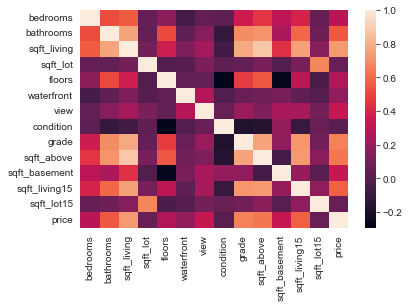

In [3]:
sns.heatmap(data = df.corr())

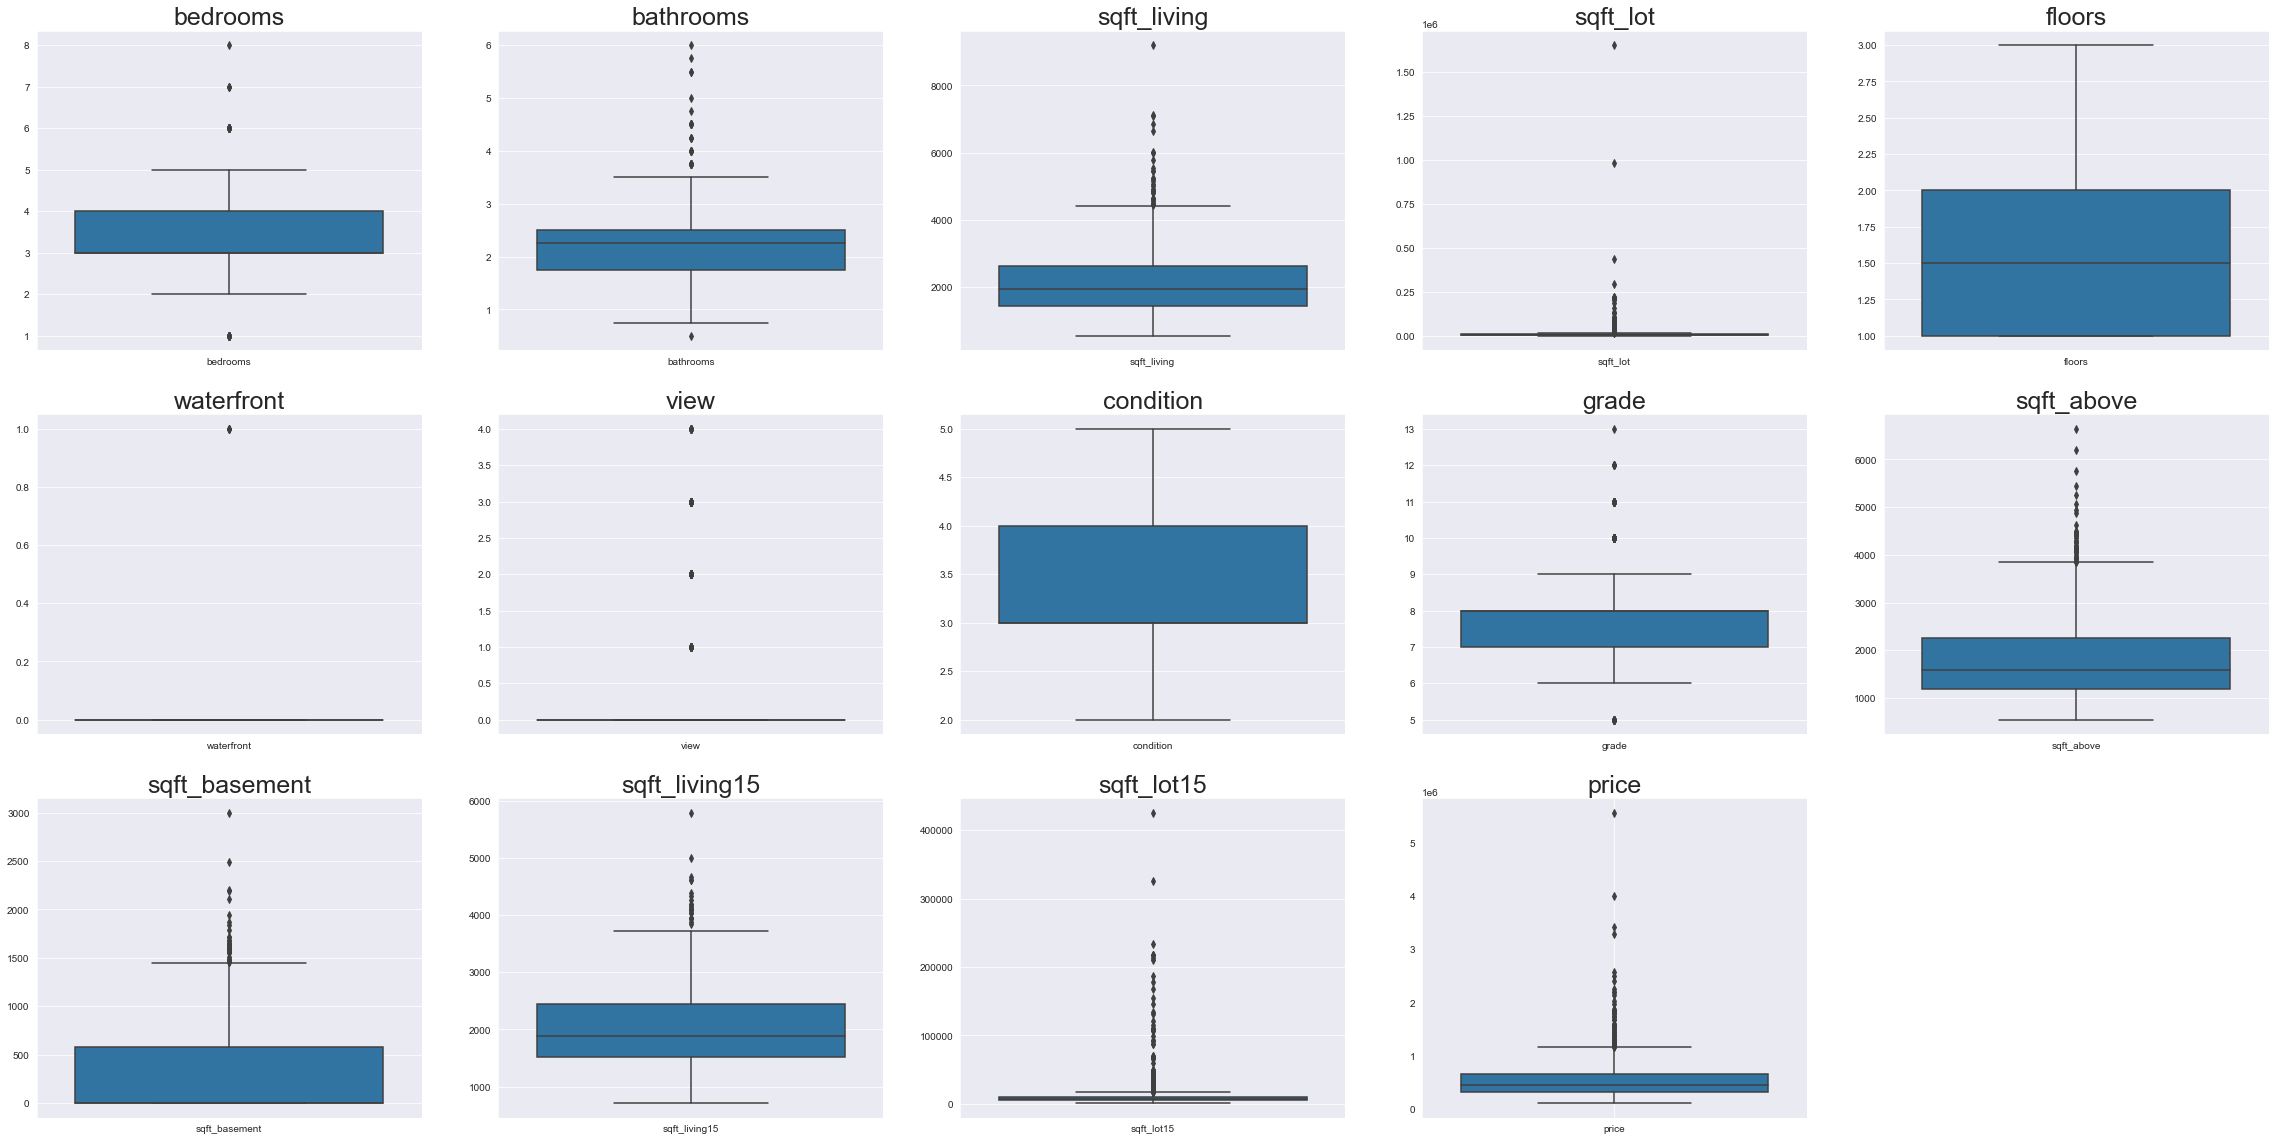

In [4]:
fig = plt.figure(figsize =(40,20))
i=1
for s in df.columns:
    plt.subplot(3,5, i)
    plt.title(s,fontsize=25)
    sns.boxplot(data=df[[s]])
    i=i+1
plt.grid()

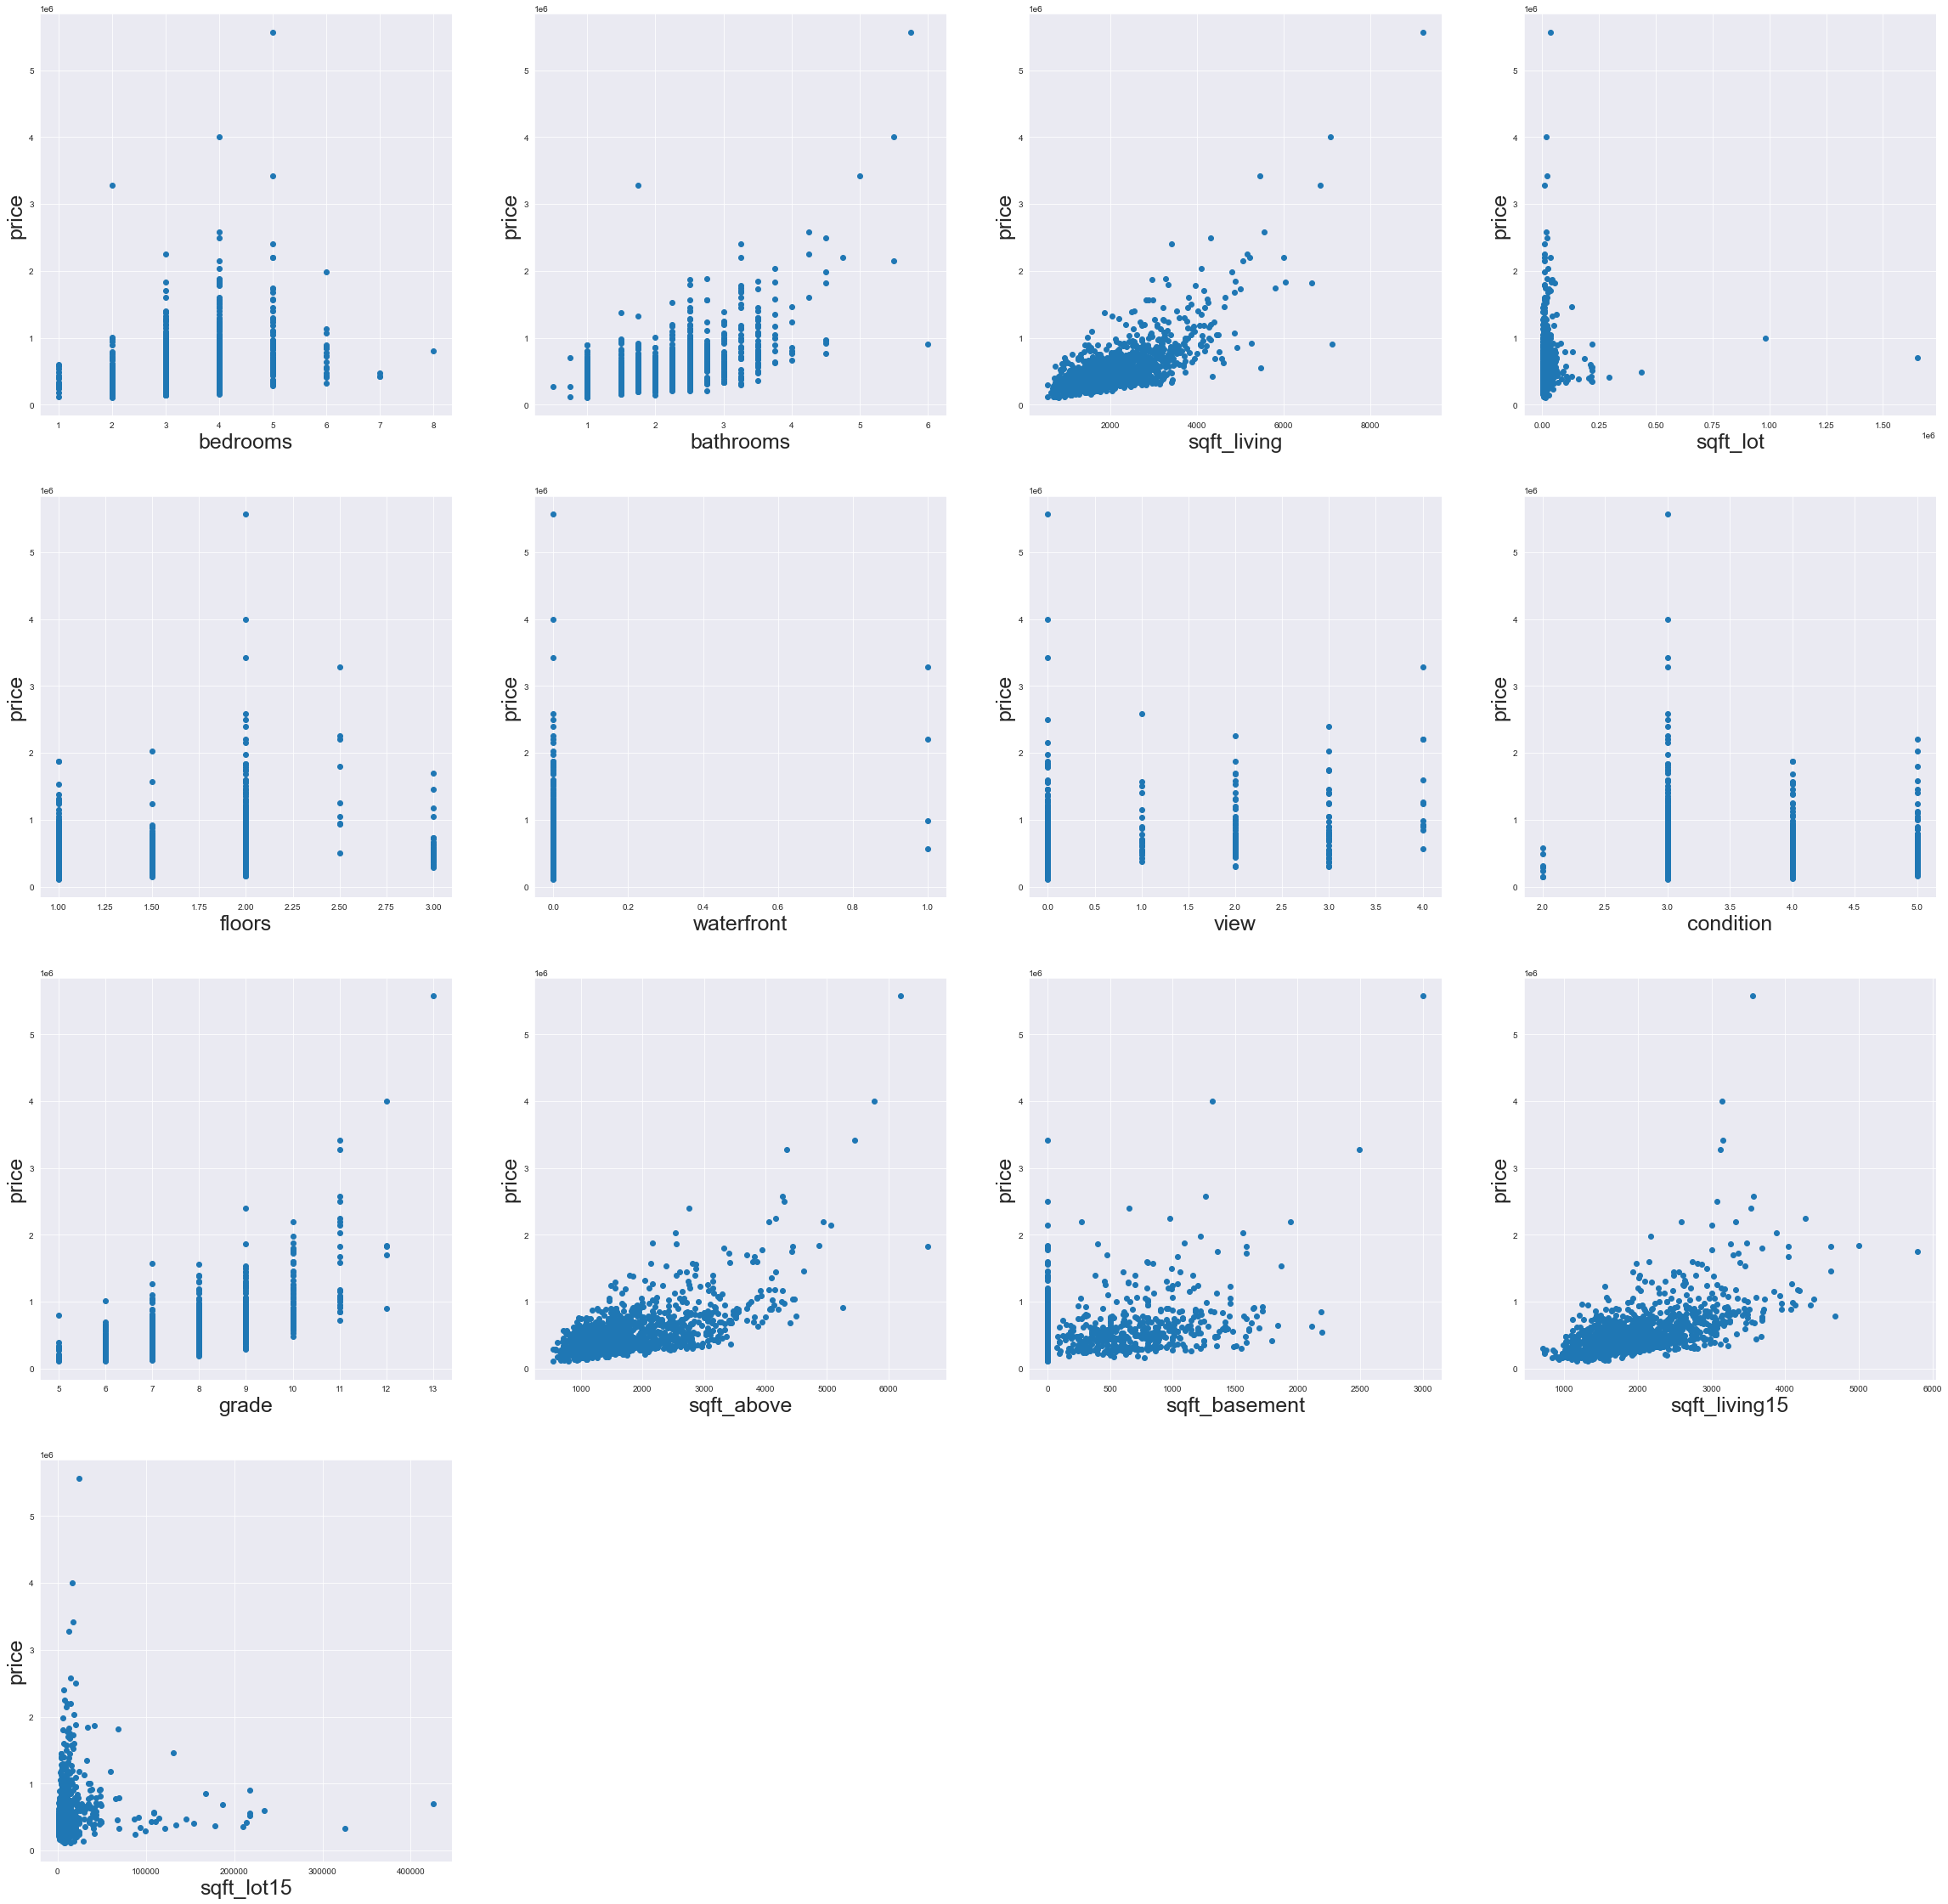

In [5]:
fig = plt.figure(figsize=(40,40))
plt.rc('axes', labelsize=25)
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(4,4,i+1)
    plt.scatter(df[col], df["price"])
    plt.xlabel(col)
    plt.ylabel("price")
plt.show()

In [6]:
def train_test_split(data, f, method='Normalize'):
    data = data.dropna()
    train = data.sample(frac=f, random_state=0)
    test = data.drop(train.index)    
    X_train = train.iloc[:, :-1]
    y_train = train.iloc[:, -1]
    X_test = test.iloc[:, :-1]
    y_test = test.iloc[:, -1]
    if(method=='Normalize'):
        mean = X_train.mean()
        sd = X_train.std()
        X_train = (X_train - mean) / sd
        X_test = (X_test - mean) / sd
        return np.array(X_train), np.array(y_train).reshape(-1,1), np.array(X_test), np.array(y_test).reshape(-1,1)
    else:
        minval = X_train.min()
        diff = X_train.max() - X_train.min()
        X_train = (X_train - minval) / diff
        X_test = (X_test - minval) / diff
        return np.array(X_train), np.array(y_train).reshape(-1,1), np.array(X_test), np.array(y_test).reshape(-1,1)

In [7]:
class LinearRegression:

    def __init__(self, X, y):
            self.X = X #(n,d)
            self.y = y #(n,1)
            self.W = np.zeros((1, X.shape[1])) #(1,d)
            self.b = 1

    def fitGD(self, n_iter=1000, lr=0.01, graph=False):
        mse = []
        for i in tqdm(range(n_iter)):
            yp = self.predict(self.X)
            mse.append(self.MSE(self.y, yp))
            # print(mse[-1])
            grad = (1/self.X.shape[0])*((self.X.T)@(yp-self.y)).T #(d,n)*(n,1) = (d,1)
            self.W = self.W - lr * grad
            self.b = self.b - lr * np.mean(yp-self.y)
        if(graph == True):
            plt.plot(mse)
            plt.show()
        return self.W, self.b
    
    def predict(self, X):
        return (X@self.W.T + self.b)

    def MSE(self, y, yp):
        return 0.5*np.mean((y-yp)**2)
    
    def RMSE(self, y, yp):
        return np.sqrt(self.MSE(y, yp))


100%|██████████| 1000/1000 [00:00<00:00, 3932.10it/s]


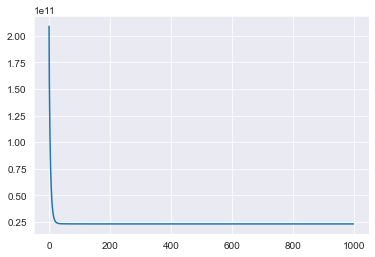

(array([[-21643.26227297,  -4576.84388659,  80005.5455832 ,
          12159.15863345,  -5762.30764529,  33942.29978297,
          67940.42945504,  32629.74577455, 108368.61248794,
          72098.31799778,  28928.95009945,  20013.36468593,
         -25361.74492824]]),
 541467.4651162786)

In [8]:
X_train, y_train, X_test, y_test = train_test_split(df, 0.75)
model = LinearRegression(X_train, y_train)
model.fitGD(lr=0.1, graph=True)

In [9]:
X_train.shape, y_train.shape

((860, 13), (860, 1))

In [10]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error

X_train, y_train, X_test, y_test = train_test_split(df.loc[:, ["sqft_living", "price"]], 0.75)
model = LR()
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test)), mean_squared_error(y_train, model.predict(X_train))


(80875199132.42342, 66848152904.228905)

In [23]:
#from sklearn.linear_model import LinearRegression as LR
#from sklearn.metrics import mean_squared_error

def GFFS(X_train, y_train, X_test, y_test):
    d = X_train.shape[1]
    remaining = list(range(d))
    selected = []
    best_n_feature_MSE = []
    for i in range(d):
        min_mse = 1e100
        min_j = -1
        for j in remaining:
            cur_features = selected + [j]
            X_train_cur = X_train[:,cur_features]
            X_test_cur = X_test[:, cur_features]
            #model = LR()
            #model.fit(X_train_cur, y_train)
            #mse = mean_squared_error(y_test, model.predict(X_test_cur))
            model = LinearRegression(X_train_cur, y_train)
            model.fitGD(lr=0.1,n_iter=10000)
            mse = model.MSE(y_test,model.predict(X_test_cur))
            if mse < min_mse:
                min_mse = mse
                min_j = j
        best_n_feature_MSE.append(min_mse)
        selected.append(min_j)
        remaining.remove(min_j)
        print((min_mse, min_j))
    return selected, best_n_feature_MSE



In [24]:
X_train, y_train, X_test, y_test = train_test_split(df, 0.75)
selected, best_n_feature_MSE = GFFS(X_train, y_train, X_test, y_test)
print(selected)
np.array(df.columns)[selected]

100%|██████████| 10000/10000 [00:00<00:00, 64509.79it/s]


(49763643351.11063, 2)


100%|██████████| 10000/10000 [00:00<00:00, 68450.16it/s]


(47111491295.85408, 0)


100%|██████████| 10000/10000 [00:00<00:00, 67034.43it/s]


(46537971257.414444, 12)


100%|██████████| 10000/10000 [00:00<00:00, 64892.15it/s]


(46155366388.29313, 7)


100%|██████████| 10000/10000 [00:00<00:00, 64067.65it/s]


(45977876965.33874, 6)


100%|██████████| 10000/10000 [00:00<00:00, 62080.08it/s]


(45857164127.12715, 3)


100%|██████████| 10000/10000 [00:00<00:00, 59268.12it/s]


(45990459106.16888, 1)


100%|██████████| 10000/10000 [00:00<00:00, 59790.68it/s]


(46350930620.93418, 4)


100%|██████████| 10000/10000 [00:00<00:00, 58828.70it/s]


(46972310561.45899, 10)


100%|██████████| 10000/10000 [00:00<00:00, 55534.57it/s]


(46972310561.45898, 9)


100%|██████████| 10000/10000 [00:01<00:00, 9639.01it/s]


(47771121498.28848, 8)


100%|██████████| 10000/10000 [00:01<00:00, 8109.43it/s]


(48449575433.71686, 11)


100%|██████████| 10000/10000 [00:01<00:00, 6399.87it/s]

(50083136368.12501, 5)
[2, 0, 12, 7, 6, 3, 1, 4, 10, 9, 8, 11, 5]


array(['sqft_living', 'bedrooms', 'sqft_lot15', 'condition', 'view',
       'sqft_lot', 'bathrooms', 'floors', 'sqft_basement', 'sqft_above',
       'grade', 'sqft_living15', 'waterfront'], dtype=object)

In [12]:
#from sklearn.linear_model import LinearRegression as LR
#from sklearn.metrics import mean_squared_error

def GBFS(X_train, y_train, X_test, y_test):
    d = X_train.shape[1]
    removed = [-1]
    selected = list(range(d))
    model = LR()
    model.fit(X_train, y_train)
    best_n_feature_MSE = [mean_squared_error(y_test, model.predict(X_test))]
    for i in range(d-1):
        min_mse = 1e100
        min_j = -1
        for j in selected:
            cur_features = [x for x in selected if x != j]
            X_train_cur = X_train[:, cur_features]
            X_test_cur = X_test[:, cur_features]
            model = LR()
            model.fit(X_train_cur, y_train)
            mse = mean_squared_error(y_test, model.predict(X_test_cur))
            if mse < min_mse:
                min_mse = mse
                min_j = j
        best_n_feature_MSE.append(min_mse)
        selected.remove(min_j)
        removed.append(min_j)
        print((min_mse, min_j))
    removed.append(selected[0])
    return removed, best_n_feature_MSE

In [13]:
X_train, y_train, X_test, y_test = train_test_split(df, 0.75)
selected, best_n_feature_MSE = GFFS(X_train, y_train, X_test, y_test)
print(selected)
np.array(df.columns)[selected]


(99527286702.22125, 2)
(94222982591.70816, 0)
(93075942514.82889, 12)
(92310732776.58624, 7)
(91955753930.67746, 6)
(91714328254.25426, 3)
(91980918212.33774, 1)
(92701861241.8683, 4)
(93944621122.91795, 9)
(95129753719.23041, 10)
(97056611380.87596, 8)
(98038429371.51434, 11)
(103048755124.17871, 5)
[2, 0, 12, 7, 6, 3, 1, 4, 9, 10, 8, 11, 5]


array(['sqft_living', 'bedrooms', 'sqft_lot15', 'condition', 'view',
       'sqft_lot', 'bathrooms', 'floors', 'sqft_above', 'sqft_basement',
       'grade', 'sqft_living15', 'waterfront'], dtype=object)

In [14]:
X_train, y_train, X_test, y_test = train_test_split(df, 0.75)
removed, best_n_feature_MSE = GBFS(X_train, y_train, X_test, y_test)
print(removed)
np.array(df.columns)[removed[1:]]

(93987278714.89546, 5)
(93769480974.1047, 11)
(91774092125.14093, 6)
(91269704158.40414, 8)
(90960543276.01627, 4)
(91738550795.11989, 7)
(91742190620.95367, 3)
(92328745371.87967, 12)
(94235604997.0478, 1)
(94235604997.04774, 2)
(99825535687.91718, 0)
(136555465556.30197, 10)
[-1, 5, 11, 6, 8, 4, 7, 3, 12, 1, 2, 0, 10, 9]


array(['waterfront', 'sqft_living15', 'view', 'grade', 'floors',
       'condition', 'sqft_lot', 'sqft_lot15', 'bathrooms', 'sqft_living',
       'bedrooms', 'sqft_basement', 'sqft_above'], dtype=object)

In [63]:
f_list = np.arange(0,13,1)
f = []
for i in range(1,14):
    f.append(f_list)
    f_list = f_list[f_list != removed[i]]
print("Feature Subsets (GBFS)")
for i in range(len(f)):
    print("Features",np.array(df.columns)[f[i]])
    print("MSE",best_n_feature_MSE[i])

Feature Subsets (GBFS)
Features ['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement' 'sqft_living15'
 'sqft_lot15']
MSE 49763643351.11063
Features ['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'view'
 'condition' 'grade' 'sqft_above' 'sqft_basement' 'sqft_living15'
 'sqft_lot15']
MSE 47111491295.85408
Features ['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'view'
 'condition' 'grade' 'sqft_above' 'sqft_basement' 'sqft_lot15']
MSE 46537971257.414444
Features ['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'condition'
 'grade' 'sqft_above' 'sqft_basement' 'sqft_lot15']
MSE 46155366388.29313
Features ['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'condition'
 'sqft_above' 'sqft_basement' 'sqft_lot15']
MSE 45977876965.33874
Features ['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'condition' 'sqft_above'
 'sqft_basement' 'sqft_lot15']
MSE 45857164127.12715
Features ['bedr

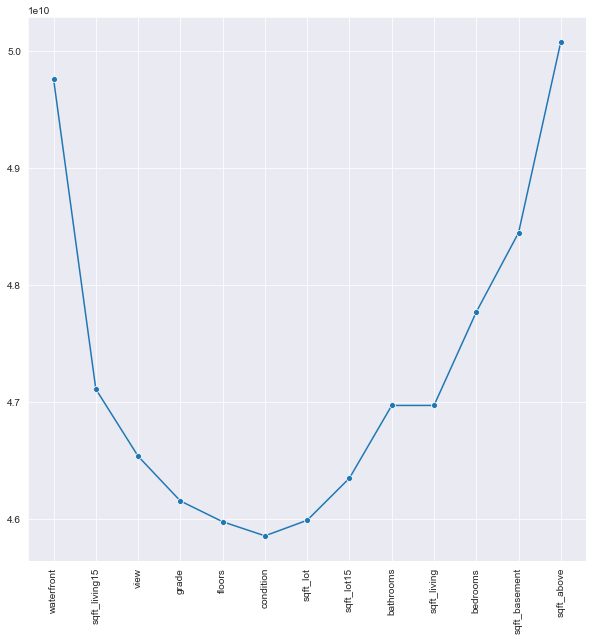

In [45]:
fig = plt.figure(figsize=(10,10))
sns.lineplot(x=(df.columns)[removed[1:]],y=best_n_feature_MSE,marker='o')
plt.xticks(rotation=90)
plt.show()